# Open AR7W data from Igor

In [1]:
import scipy.io as sio
import numpy as np
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [2]:
data_dir = Path("/Users/mzahn/data/Labrador_AR7W/igor_ds/AR7W")
matfile = data_dir / "export_2024 2024d42 5 days.mat"

mat = sio.loadmat(matfile, squeeze_me=True, struct_as_record=False)

In [3]:
Section = mat["Section"]

In [4]:
Section._fieldnames

['Dist_grid',
 'FID_first_grid',
 'FID_grid',
 'Lat_grid',
 'Lon_grid',
 'M_grid',
 'S_grid',
 'Sig0grid',
 'Sig1grid',
 'Sig2grid',
 'Sig_grid',
 'TOPO_grid',
 'T_grid',
 'YD_first_grid',
 'YD_grid',
 'Y_grid',
 'V_grid']

In [9]:
def decimal_year_to_datetime(decimal_year):
    decimal_year = np.asarray(decimal_year)

    year = np.floor(decimal_year).astype(int)
    frac = decimal_year - year

    start_of_year = pd.to_datetime(year, format="%Y")
    start_next_year = pd.to_datetime(year + 1, format="%Y")

    # Length of year in nanoseconds (int64)
    year_length_ns = (start_next_year - start_of_year).values.astype("timedelta64[ns]").astype(np.int64)

    # Fractional offset in nanoseconds
    offset_ns = (frac * year_length_ns).astype(np.int64)

    return start_of_year.values + offset_ns.astype("timedelta64[ns]")

In [11]:
data_dir = Path("/Users/mzahn/data/Labrador_AR7W/igor_ds/AR7W")

datasets = []

for matfile in sorted(data_dir.glob("*.mat")):
    # print(matfile)
    mat = sio.loadmat(matfile, squeeze_me=True, struct_as_record=False)
    Section = mat["Section"]

    # Dimensions
    station = np.arange(Section.Lat_grid.size)
    pressure = Section.V_grid

    # Convert decimal year to datetime
    time = decimal_year_to_datetime(Section.YD_grid)
    # print(time)
    ds = xr.Dataset(
        data_vars={
            "salinity": (("station", "pressure"), Section.S_grid),
            "temperature": (("station", "pressure"), Section.T_grid),
            "sigma": (("station", "pressure"), Section.Sig_grid),
            "sigma0": (("station", "pressure"), Section.Sig0grid),
            "sigma1": (("station", "pressure"), Section.Sig1grid),
            "sigma2": (("station", "pressure"), Section.Sig2grid),
        },
        coords={
            "station": station,
            "pressure": ("pressure", pressure),
            "time": ("station", time),
            "latitude": ("station", Section.Lat_grid),
            "longitude": ("station", Section.Lon_grid),
            "distance": ("station", Section.Dist_grid),
            "bottom_depth": ("station", Section.TOPO_grid),
        },
        attrs={
            "source": "Labrador Sea AR7W hydrography",
            "original_file": matfile.name,
        }
    )
    
    datasets.append(ds)

In [12]:
# combine all of them
datasets = [ds.swap_dims({"station": "time"}) for ds in datasets]
ar7w_ds = xr.concat(datasets, dim="time").sortby("time")

In [15]:
# save dataset
ar7w_ds.to_netcdf("/Users/mzahn/data/Labrador_AR7W/igor_ds/AR7W_netcdf/igor_ar7w.nc")

### Plot data

In [3]:
# open dataset
ar7w_ds = xr.open_dataset("/Users/mzahn/data/Labrador_AR7W/igor_ds/AR7W_netcdf/igor_ar7w.nc")

In [7]:
tmp = ar7w_ds.sel(time='1993')

In [9]:
tmp_dist = tmp.swap_dims({'time':'distance'}).sortby('distance')

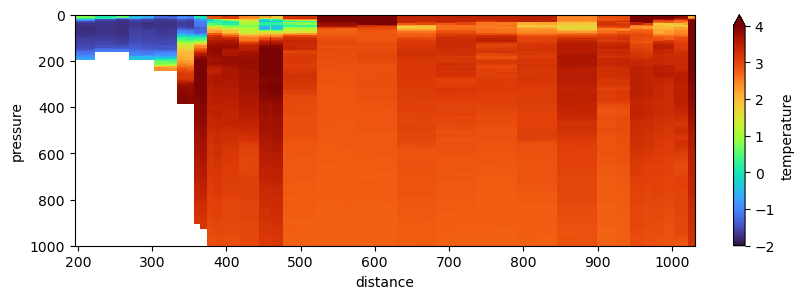

In [13]:
tmp_dist.temperature.plot(x='distance',y='pressure',vmin=-2,vmax=4,cmap='turbo',figsize=[10,3])
plt.ylim(1000,0);

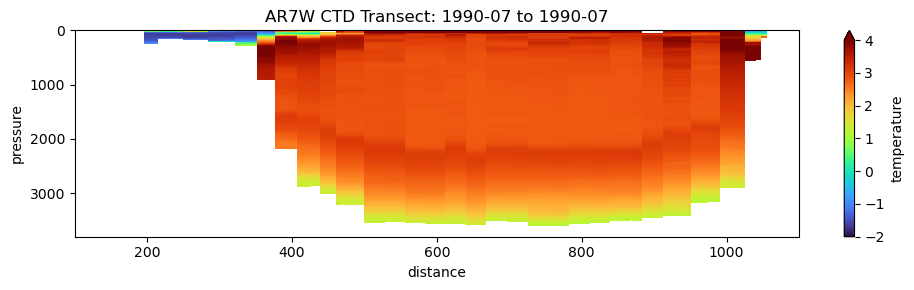

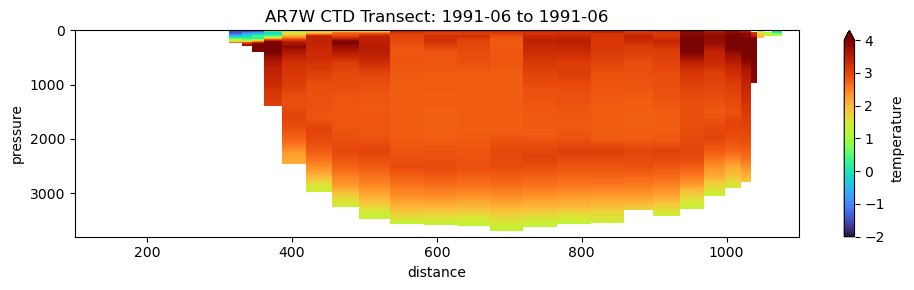

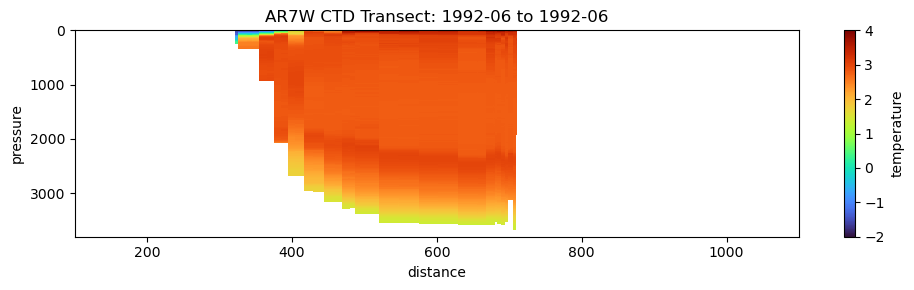

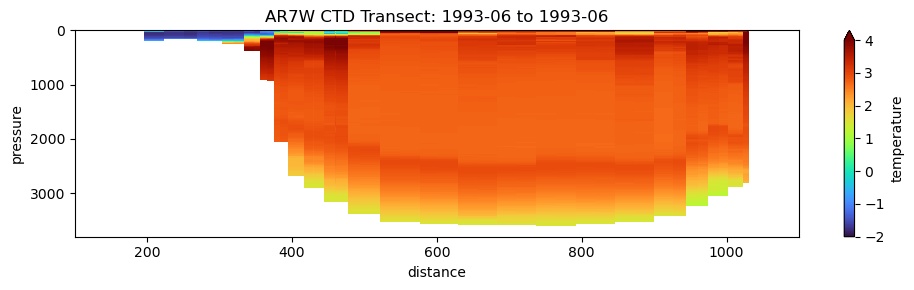

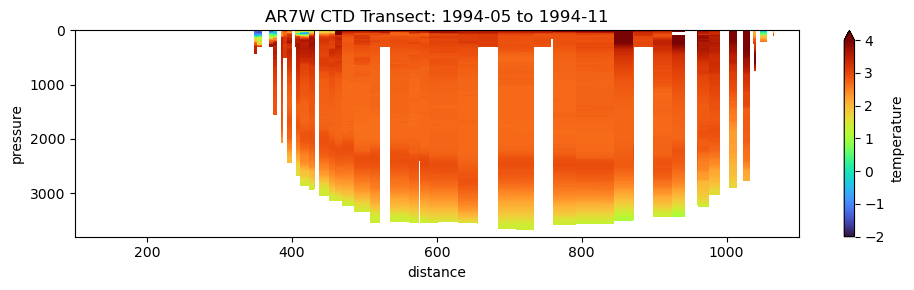

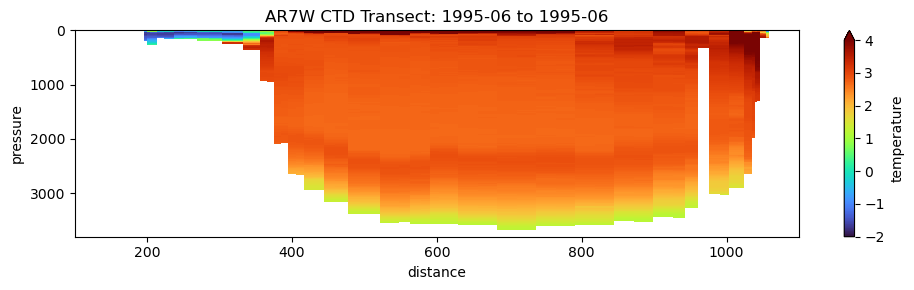

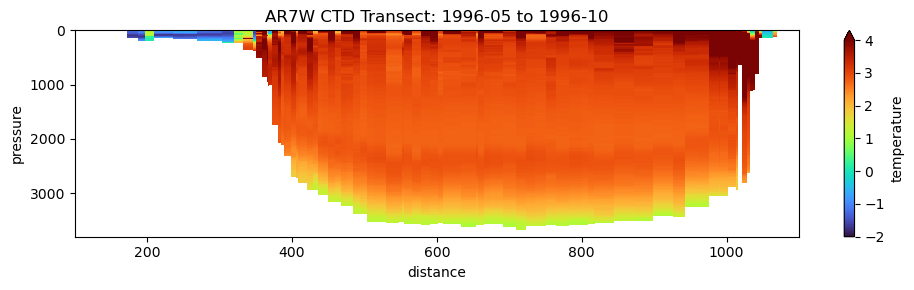

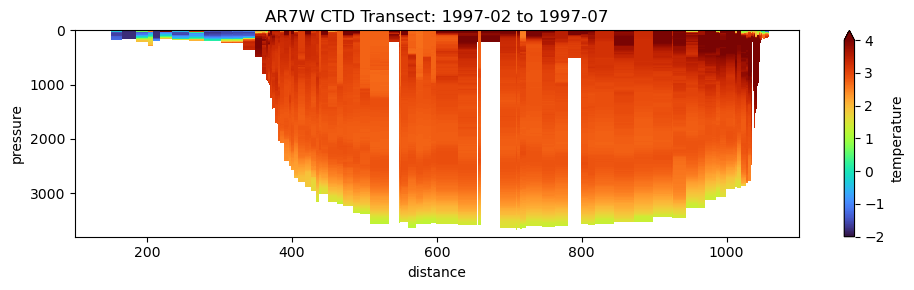

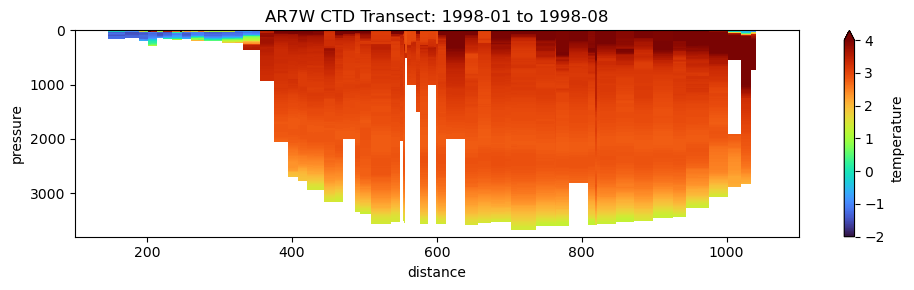

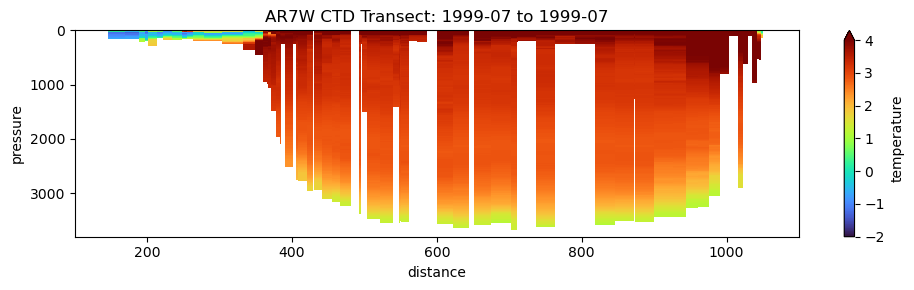

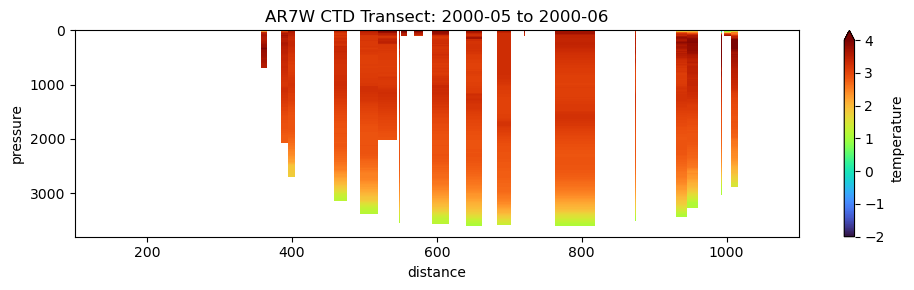

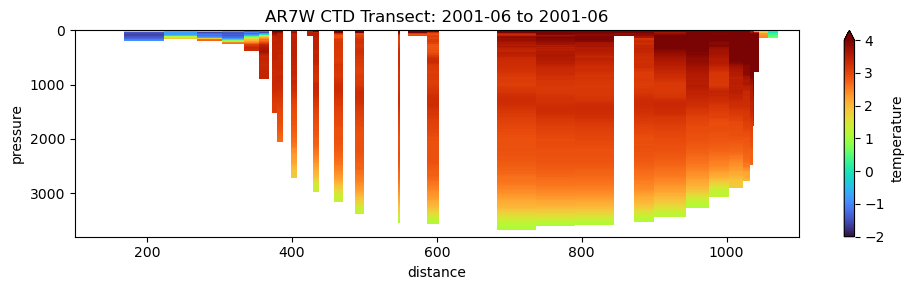

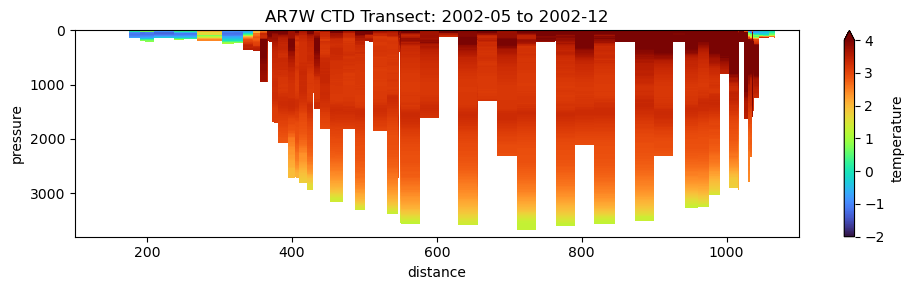

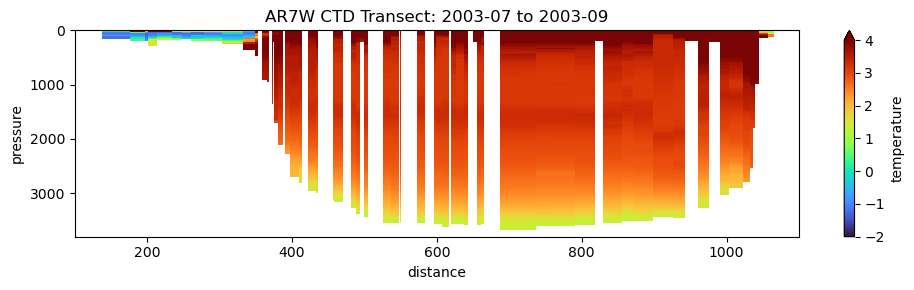

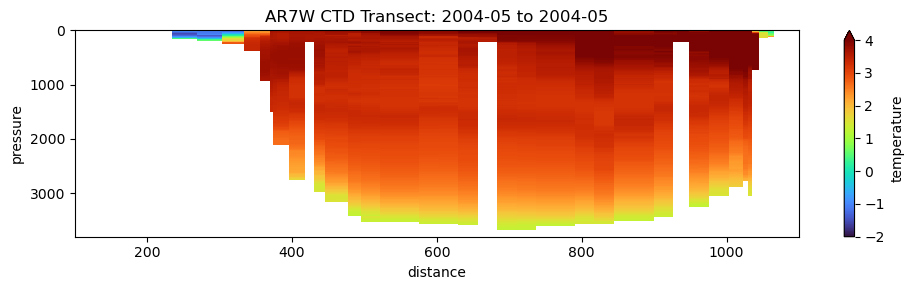

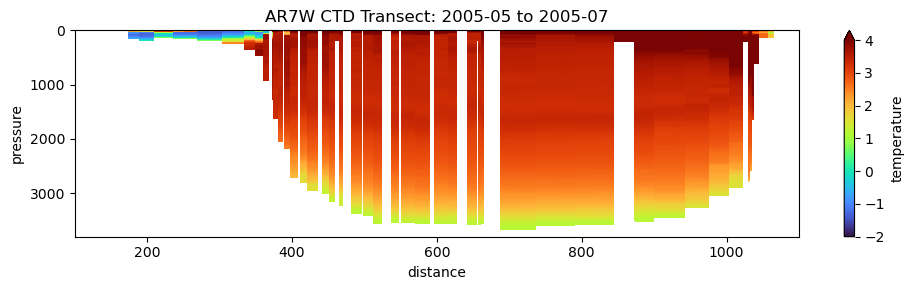

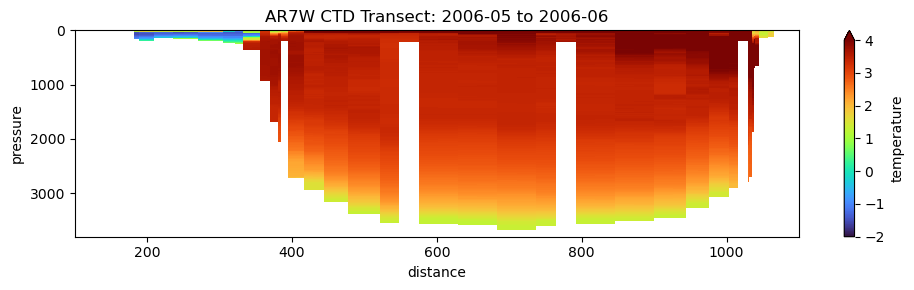

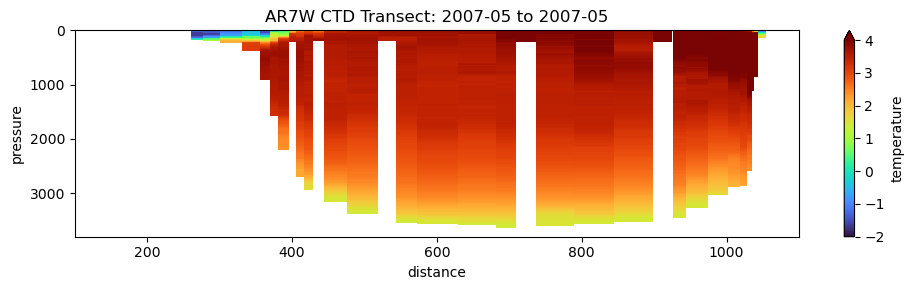

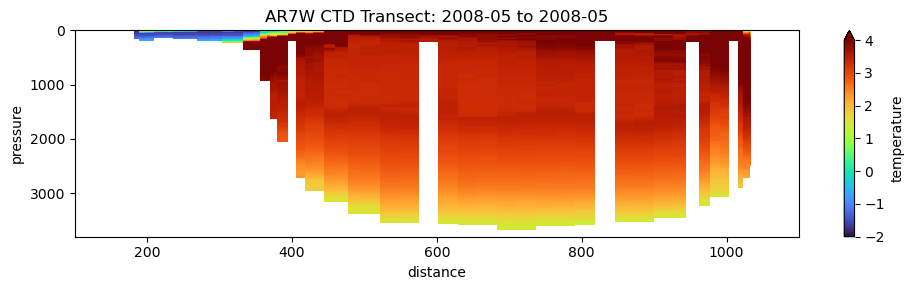

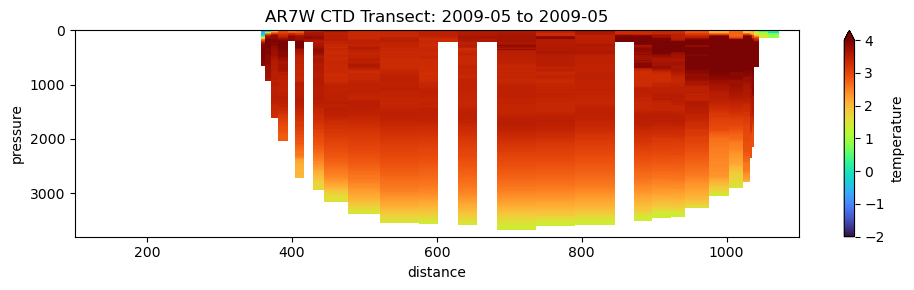

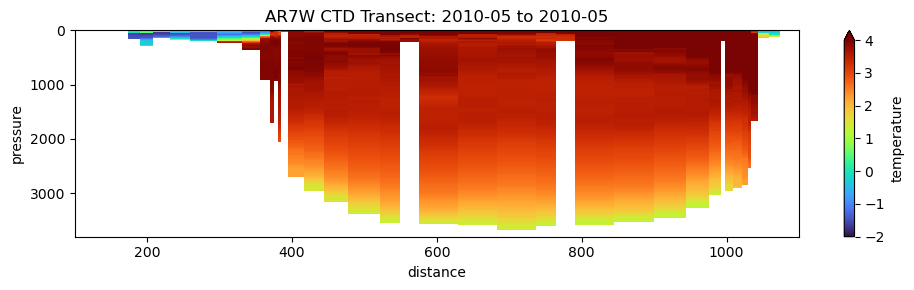

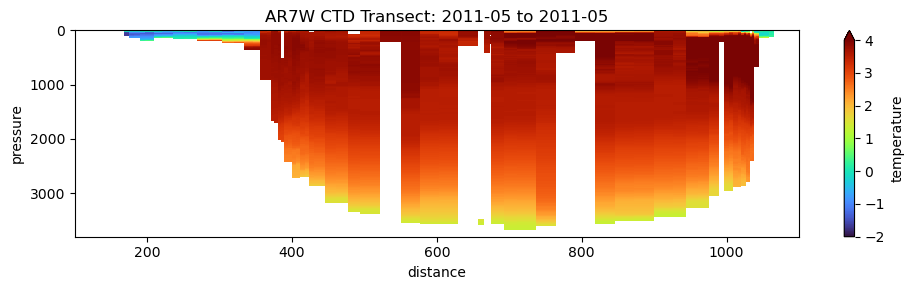

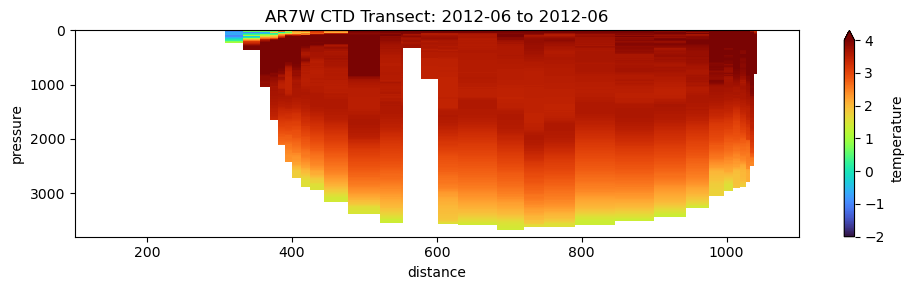

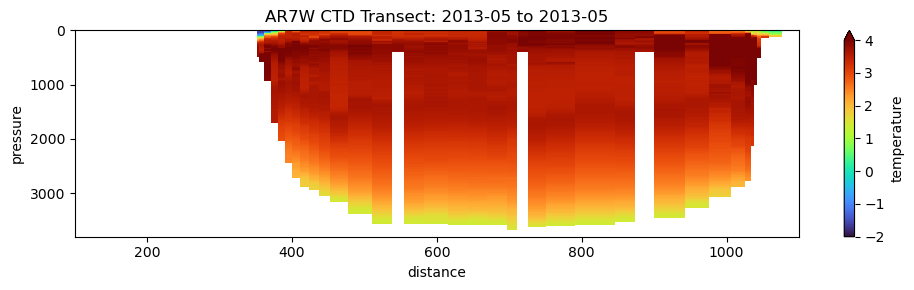

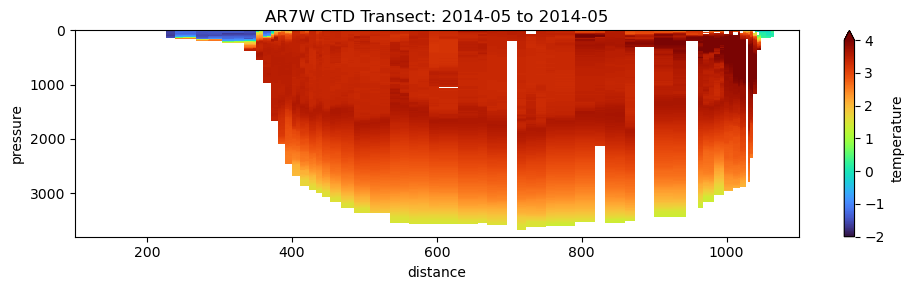

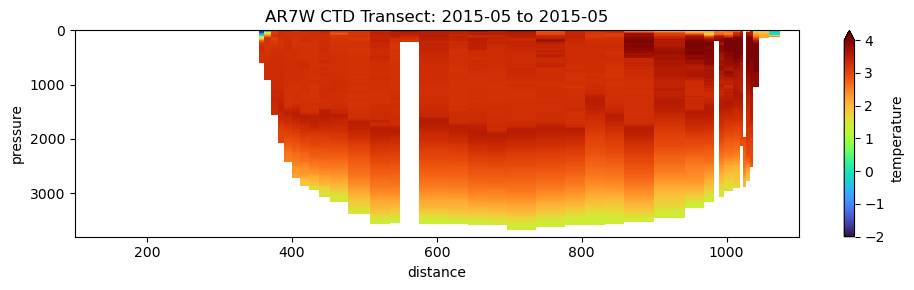

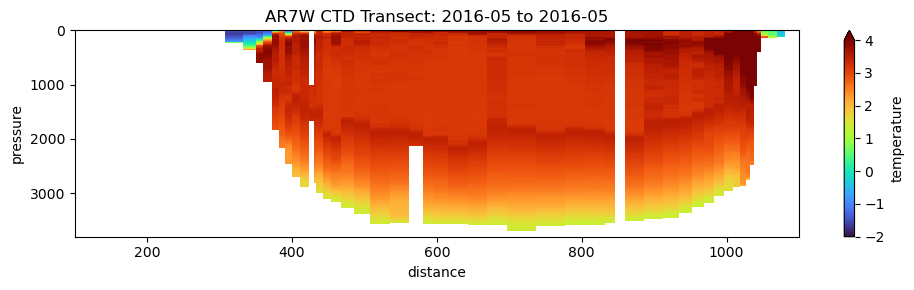

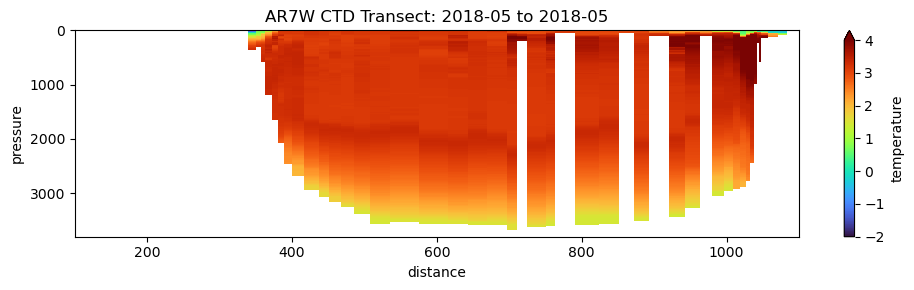

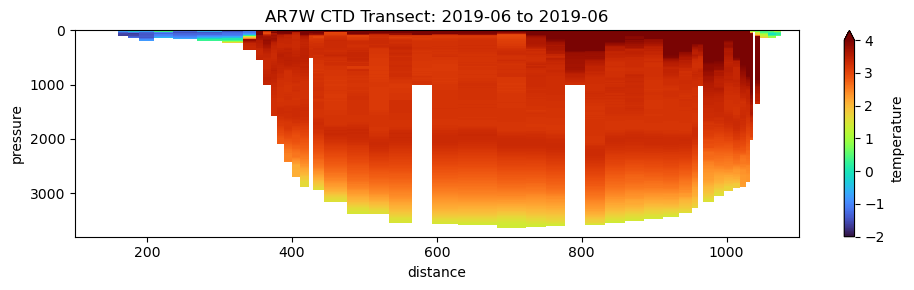

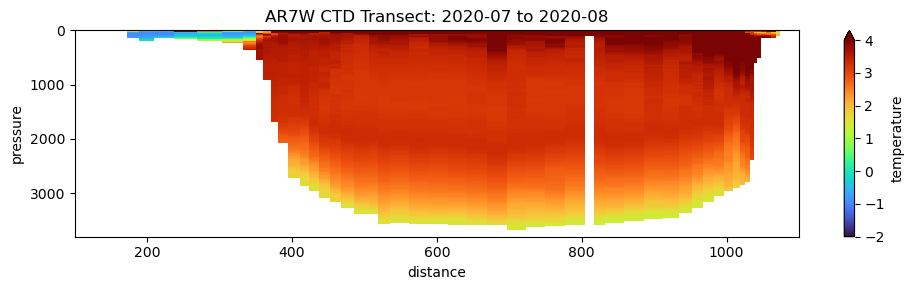

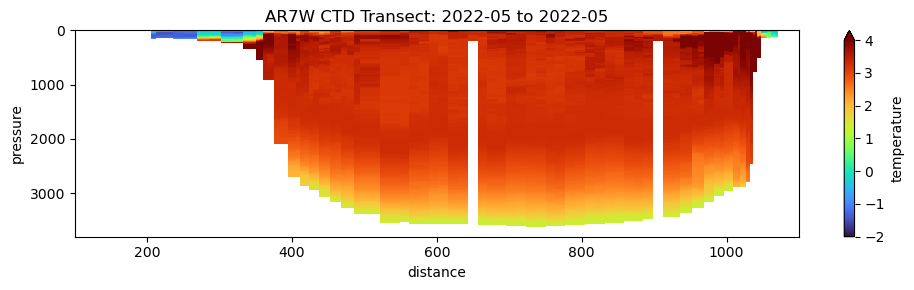

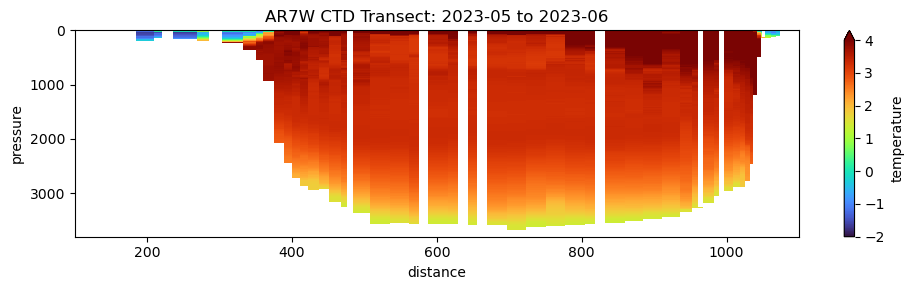

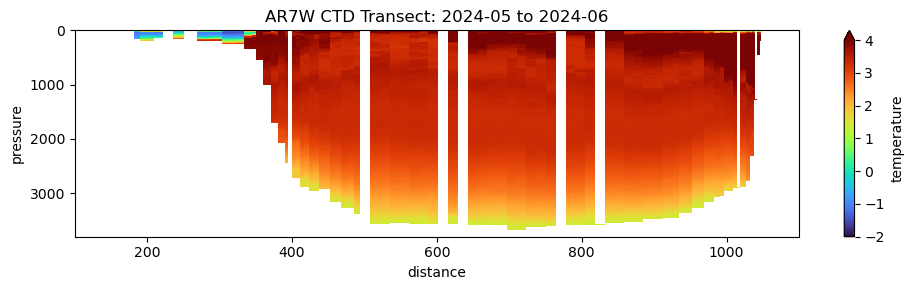

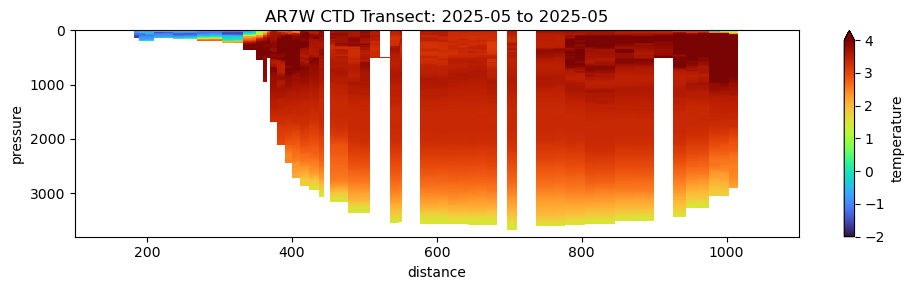

In [17]:
# get unique years present in the dataset
years = pd.DatetimeIndex(ar7w_ds.time.values).year
years = np.unique(years)

for yr in years:
    tmp = ar7w_ds.sel(time=str(yr))

    # skip empty years (just in case)
    if tmp.time.size == 0:
        continue

    # swap to distance for plotting
    tmp_dist = (
        tmp
        .swap_dims({"time": "distance"})
        .sortby("distance")
    )

    # get start and end dates
    t0 = pd.to_datetime(tmp.time.min().values)
    t1 = pd.to_datetime(tmp.time.max().values)

    title = (
        f"AR7W CTD Transect: "
        f"{t0.year}-{t0.month:02d} to {t1.year}-{t1.month:02d}"
    )

    # plot
    plt.figure(figsize=(10, 3))
    tmp_dist.temperature.plot(
        x="distance",
        y="pressure",
        vmin=-2,
        vmax=4,
        cmap="turbo",
        add_colorbar=True
    )

    plt.ylim(3800, 0)
    plt.xlim(100,1100)
    plt.title(title)
    plt.tight_layout()
    plt.show()

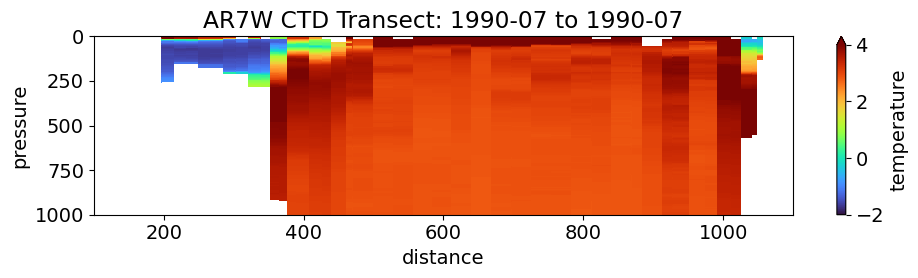

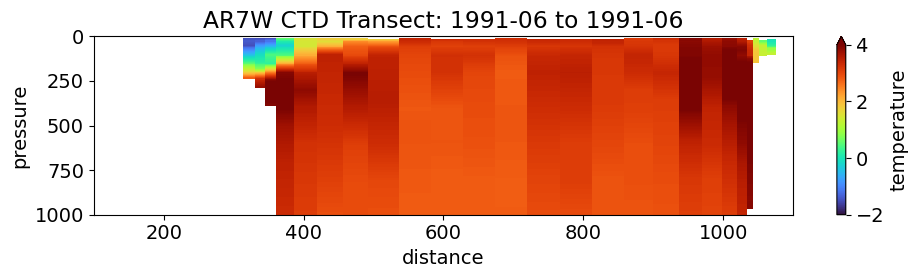

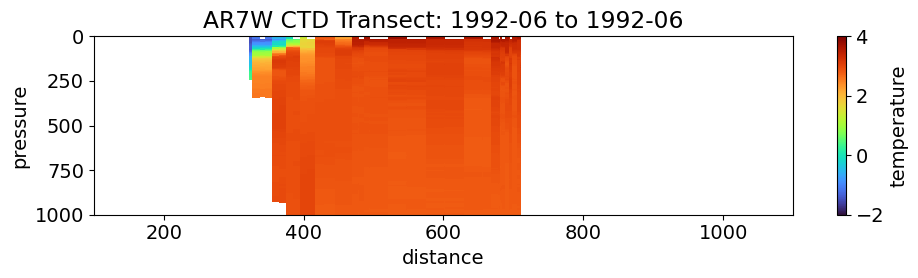

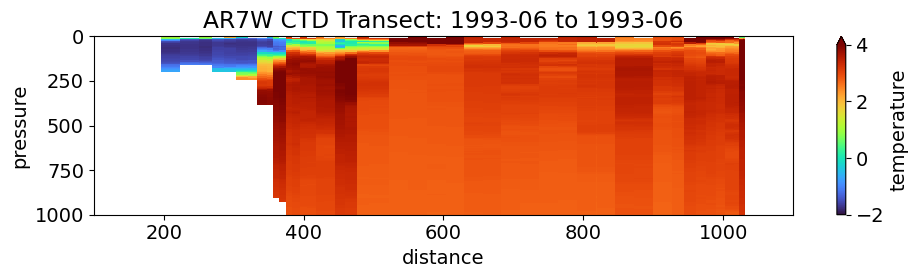

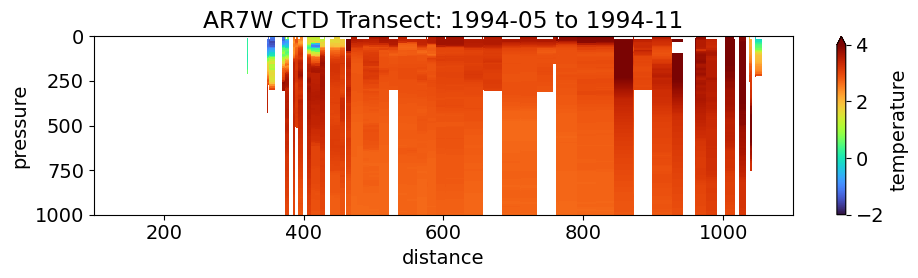

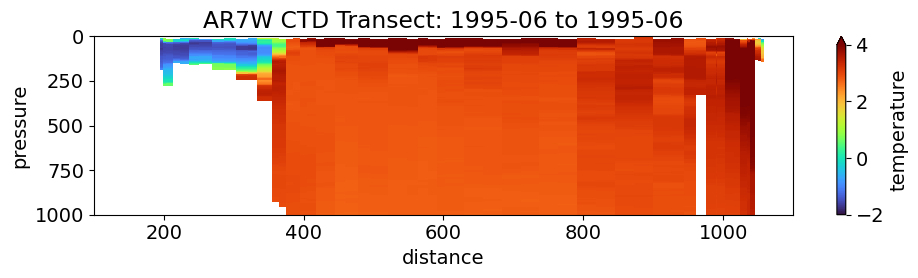

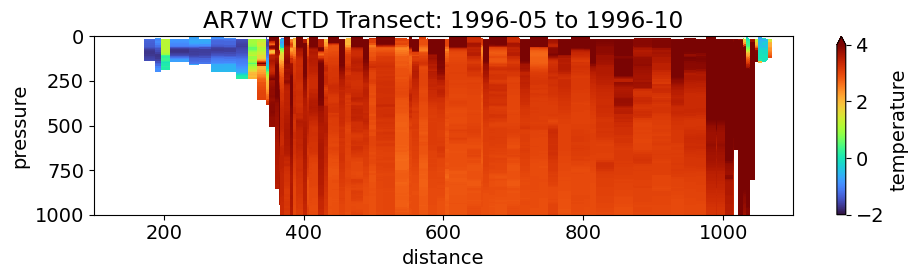

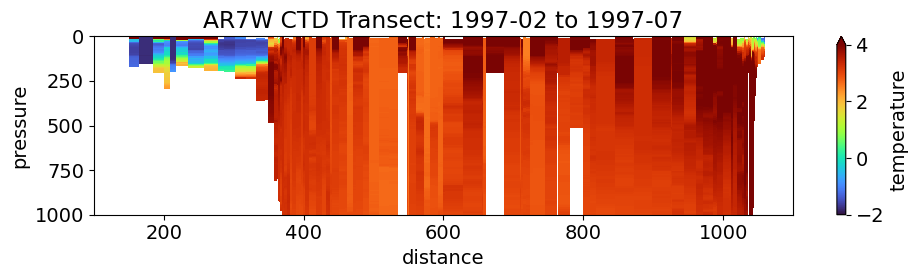

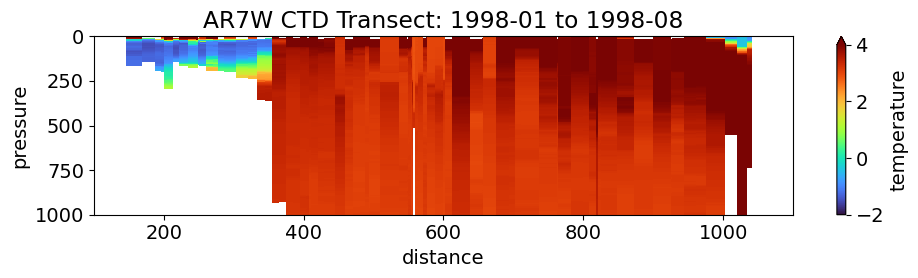

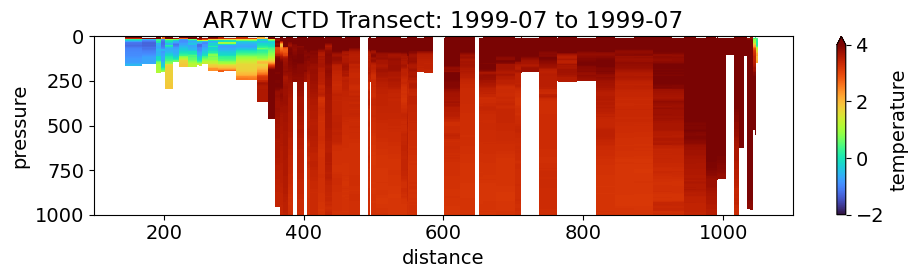

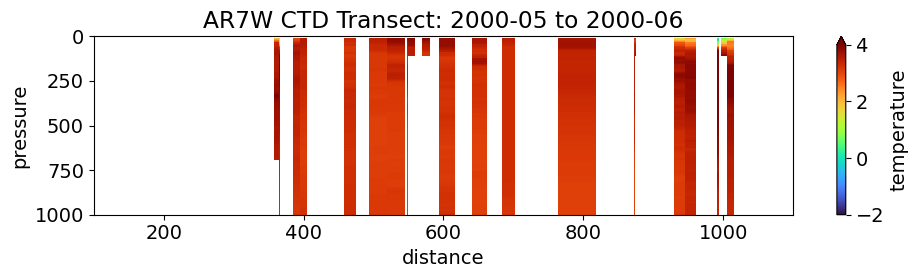

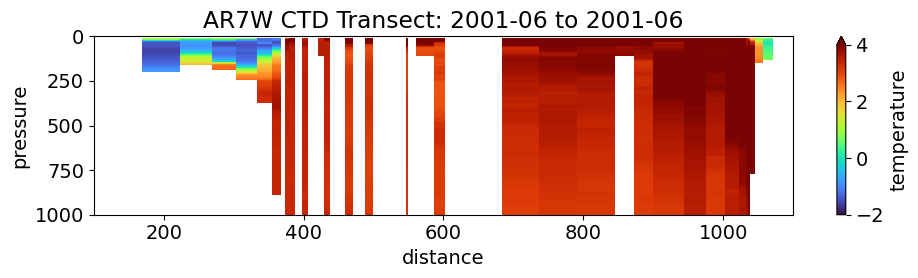

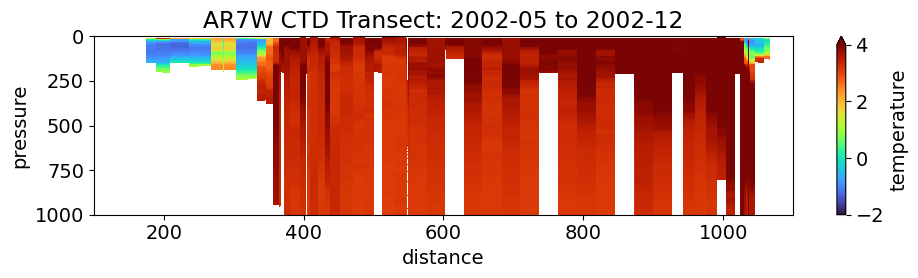

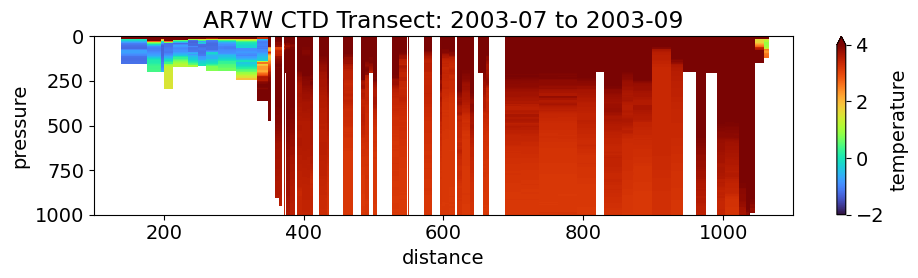

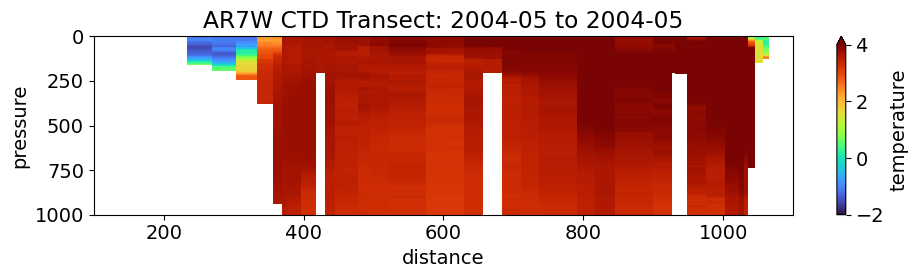

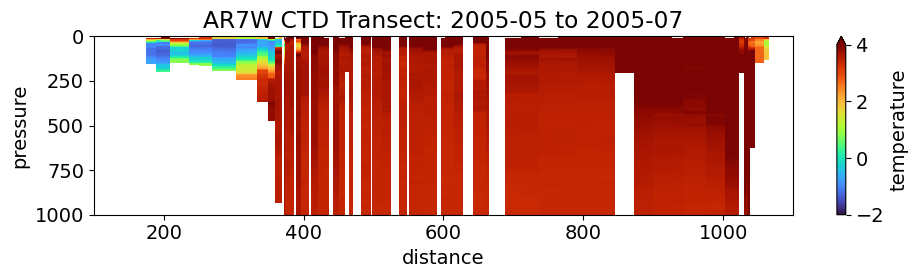

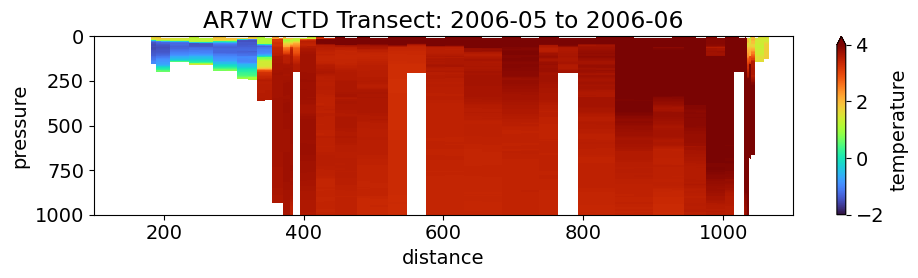

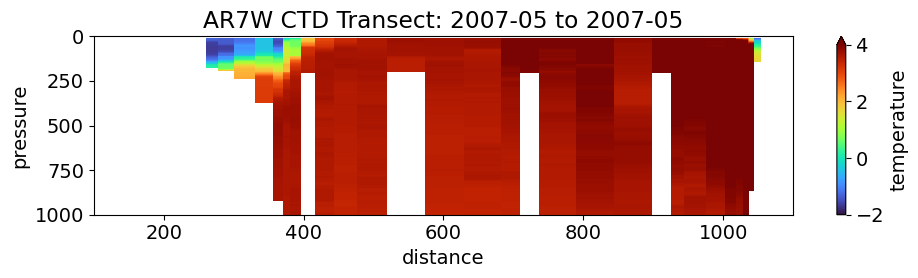

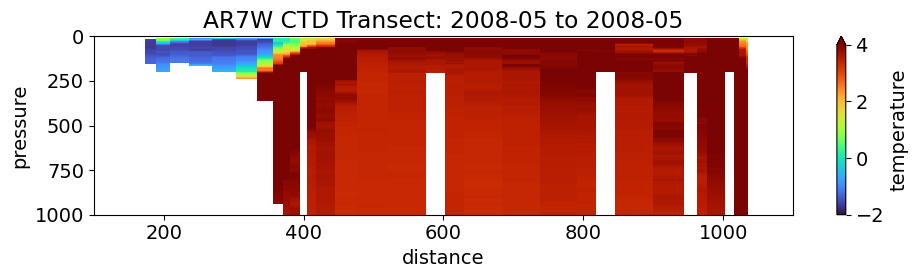

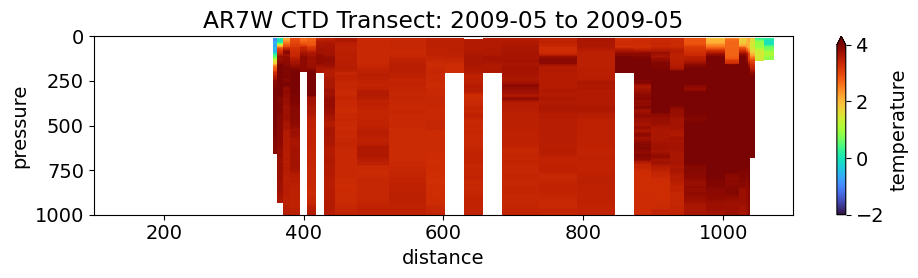

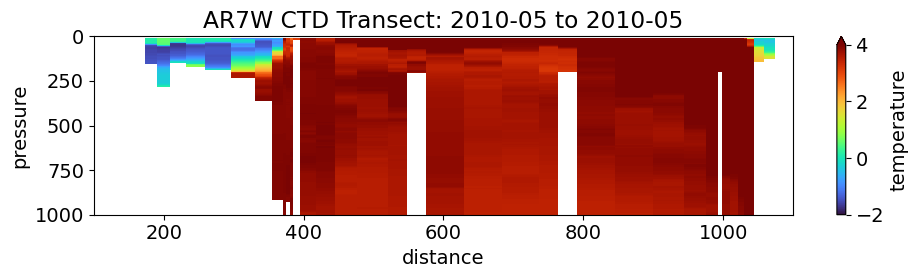

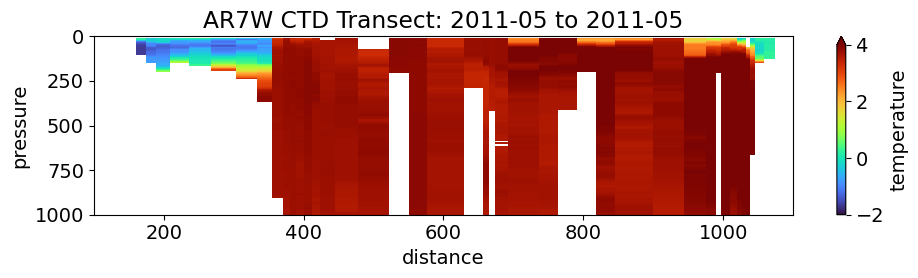

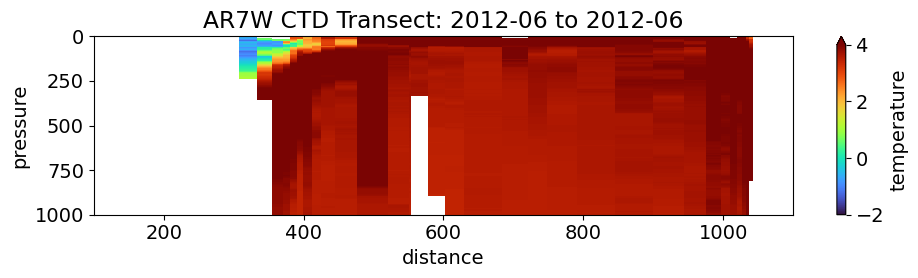

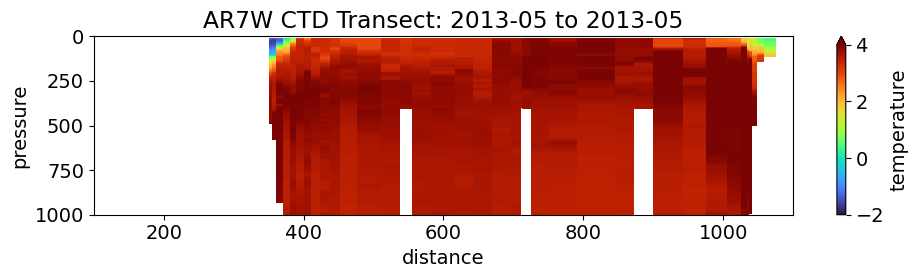

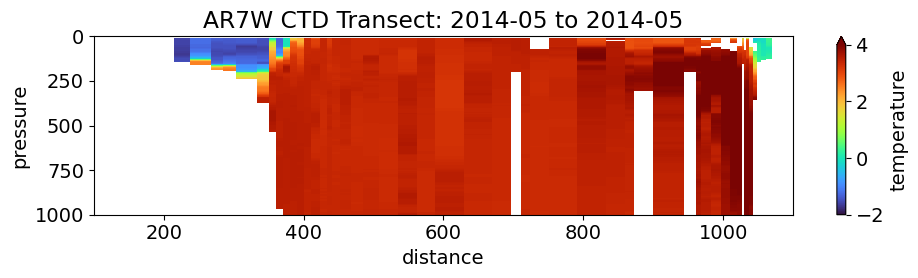

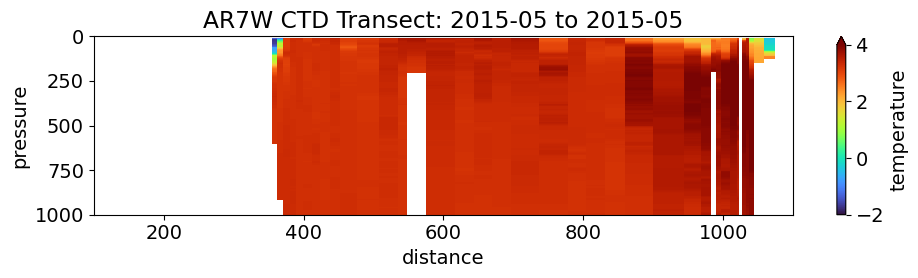

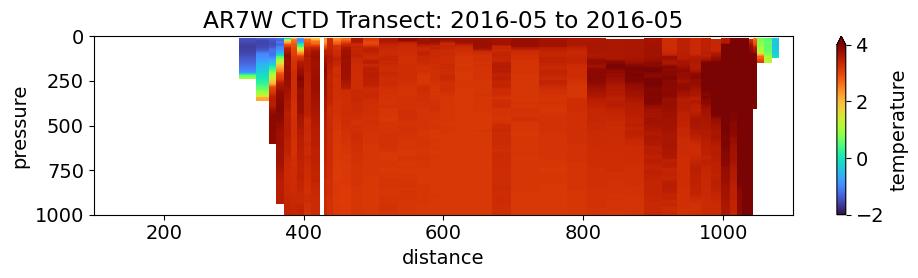

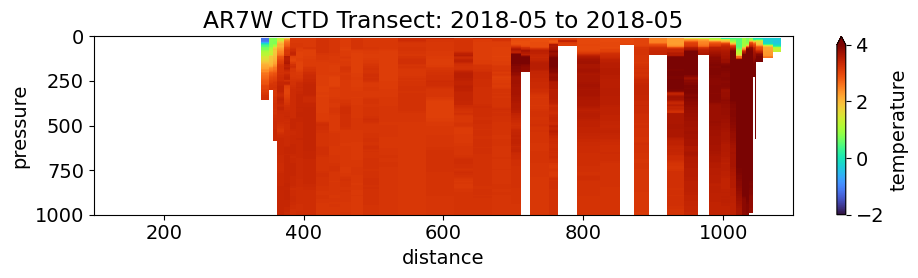

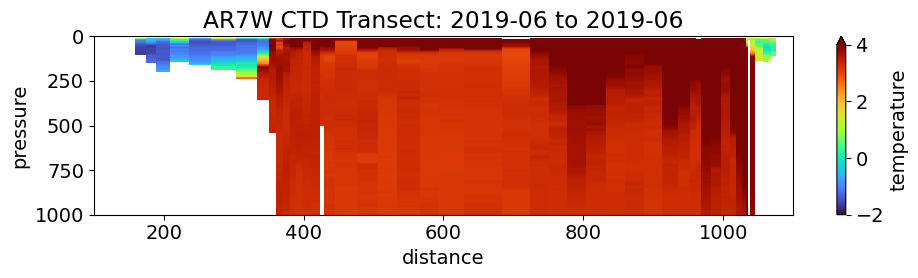

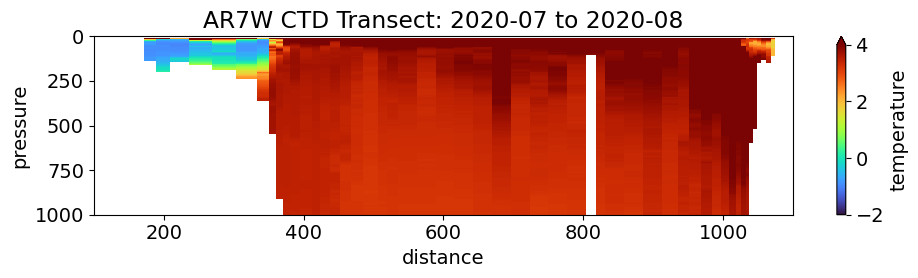

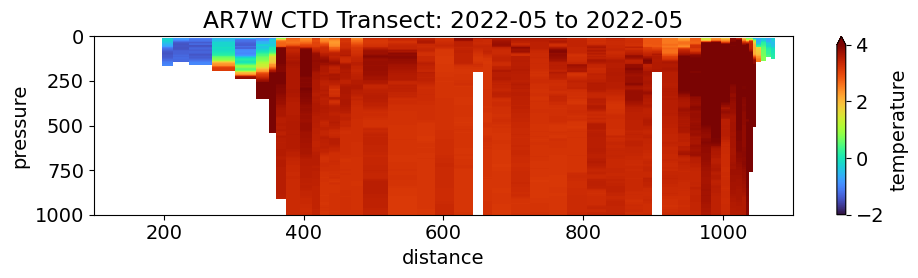

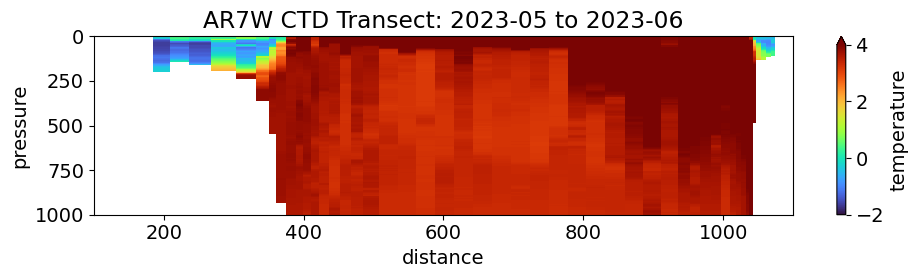

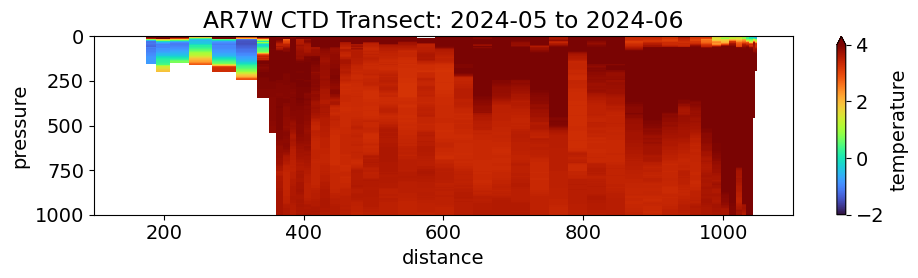

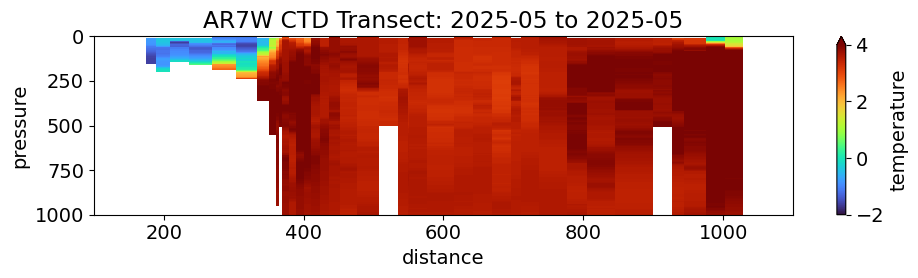

In [377]:
# get unique years present in the dataset
years = pd.DatetimeIndex(ar7w_ds.time.values).year
years = np.unique(years)

for yr in years:
    tmp = ar7w_ds.sel(time=str(yr))

    # skip empty years (just in case)
    if tmp.time.size == 0:
        continue

    # REMOVE DUPLICATE PROFILES (lat/lon) FOR THIS YEAR
    coords_df = pd.DataFrame({
        "lat": tmp.latitude.values,
        "lon": tmp.longitude.values
    })

    # keep first occurrence of each (lat, lon)
    duplicate_mask = coords_df.duplicated()
    tmp = tmp.isel(time=~duplicate_mask)

    # swap to distance for plotting
    tmp_dist = (
        tmp
        .swap_dims({"time": "distance"})
        .sortby("distance")
    )

    # get start and end dates
    t0 = pd.to_datetime(tmp.time.min().values)
    t1 = pd.to_datetime(tmp.time.max().values)

    title = (
        f"AR7W CTD Transect: "
        f"{t0.year}-{t0.month:02d} to {t1.year}-{t1.month:02d}"
    )

    # plot
    plt.figure(figsize=(10, 3))
    tmp_dist.temperature.plot(
        x="distance",
        y="pressure",
        vmin=-2,
        vmax=4,
        cmap="turbo",
        add_colorbar=True
    )

    plt.ylim(1000, 0)
    plt.xlim(100, 1100)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [255]:
# plot just 2024
tmp = ar7w_ds.sel(time='2024').swap_dims({'time':'distance'}).sortby('distance')

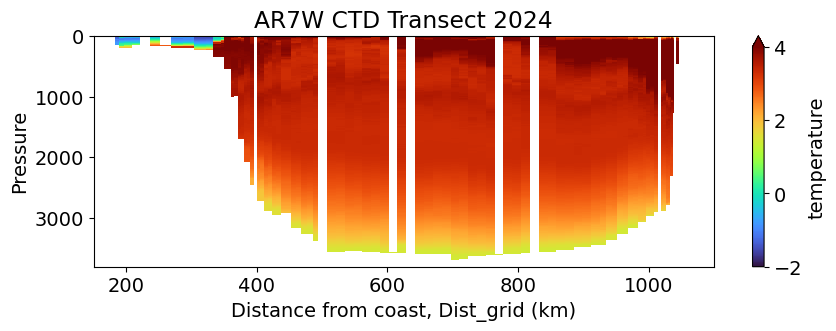

In [257]:
plt.figure(figsize=(10, 3))
tmp.temperature.plot(
    x="distance",
    y="pressure",
    vmin=-2,
    vmax=4,
    cmap="turbo",
    add_colorbar=True
)
plt.title('AR7W CTD Transect 2024')
plt.xlabel('Distance from coast, Dist_grid (km)')
plt.ylabel('Pressure')
plt.ylim(3800, 0)
plt.xlim(150,1100);

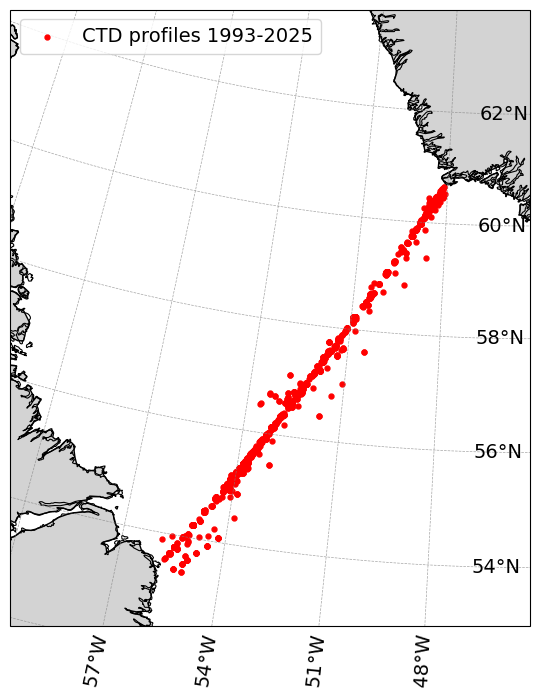

In [25]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-60, -45, 53, 63], crs=ccrs.PlateCarree())

# Plot points for 1993
ax.scatter(
    ar7w_ds.longitude.values,
    ar7w_ds.latitude.values,
    s=50,
    color="red", marker='.',
    transform=ccrs.PlateCarree(),
    label='CTD profiles 1993-2025')

# Title and legend
# plt.title("Matching AR7W Profiles: 1993 and 2024\nSatellite SLA 2024-06-12")
plt.legend(loc='upper left')
plt.show()

In [114]:
ar7w_ds.sel(time='2024')

<xarray.Dataset> Size: 4MB
Dimensions:       (time: 108, pressure: 763)
Coordinates:
    station       (time) int64 864B ...
  * pressure      (pressure) uint16 2kB 5 10 15 20 25 ... 3800 3805 3815 3820
  * time          (time) datetime64[ns] 864B 2024-05-29T13:09:40.645163918 .....
    latitude      (time) float64 864B 55.73 55.84 55.84 ... 53.8 53.68 53.68
    longitude     (time) float64 864B -53.51 -53.4 -53.4 ... -55.54 -55.54
    distance      (time) float64 864B ...
    bottom_depth  (time) float64 864B ...
Data variables:
    salinity      (time, pressure) float64 659kB ...
    temperature   (time, pressure) float64 659kB ...
    sigma         (time, pressure) float64 659kB ...
    sigma0        (time, pressure) float64 659kB ...
    sigma1        (time, pressure) float64 659kB ...
    sigma2        (time, pressure) float64 659kB ...
Attributes:
    source:         Labrador Sea AR7W hydrography
    original_file:  00l3_ 2000d41 8 days.mat

In [154]:
ar7w_ds.sel(time='2024').longitude

<xarray.DataArray 'longitude' (time: 108)> Size: 864B
array([-53.5112, -53.395 , -53.395 , -53.2537, -53.2537, -53.1218, -53.1218,
       -53.1218, -53.1218, -52.8998, -52.8998, -52.8998, -52.6778, -52.6778,
       -52.4622, -52.4622, -52.2333, -52.2333, -52.2333, -52.0177, -52.0177,
       -52.0177, -52.0177, -51.7908, -51.7908, -51.5628, -51.5628, -51.3438,
       -51.3438, -51.1113, -51.1113, -50.8733, -50.8733, -50.8733, -50.66  ,
       -50.66  , -50.4135, -50.4135, -50.4135, -50.1847, -50.1847, -49.9535,
       -49.9535, -49.7222, -49.7222, -49.4753, -49.4753, -49.3155, -49.3155,
       -49.1682, -49.1682, -49.0307, -49.0307, -48.6123, -48.6123, -48.5428,
       -48.5428, -48.4108, -48.4108, -48.4108, -48.4108, -48.4108, -48.5097,
       -48.5097, -48.4507, -48.4507, -48.4507, -48.6852, -48.6852, -48.6852,
       -48.7888, -48.7888, -48.9022, -48.9022, -53.628 , -53.628 , -53.7302,
       -53.7302, -53.826 , -53.826 , -53.9087, -53.9087, -53.9087, -53.9922,
       -53.9922, -54.0602, -54.0602, -54.137 , -54.137 , -54.2155, -54.2155,
       -54.2887, -54.2887, -54.486 , -54.486 , -54.7507, -54.7507, -55.026 ,
       -55.026 , -55.026 , -55.026 , -55.2473, -55.2473, -55.2473, -55.4337,
       -55.4337, -55.5448, -55.5448])
Coordinates:
    station       (time) int64 864B ...
  * time          (time) datetime64[ns] 864B 2024-05-29T13:09:40.645163918 .....
    latitude      (time) float64 864B 55.73 55.84 55.84 ... 53.8 53.68 53.68
    longitude     (time) float64 864B -53.51 -53.4 -53.4 ... -55.54 -55.54
    distance      (time) float64 864B ...
    bottom_depth  (time) float64 864B ...

In [152]:
ar7w_ds.sel(time='2024').latitude

<xarray.DataArray 'latitude' (time: 108)> Size: 864B
array([55.7267, 55.8447, 55.8447, 55.9795, 55.9795, 56.1117, 56.1117, 56.1117,
       56.1117, 56.324 , 56.324 , 56.324 , 56.538 , 56.538 , 56.7462, 56.7462,
       56.9528, 56.9528, 56.9528, 57.1643, 57.1643, 57.1643, 57.1643, 57.3782,
       57.3782, 57.5863, 57.5863, 57.802 , 57.802 , 58.009 , 58.009 , 58.2187,
       58.2187, 58.2187, 58.4332, 58.4332, 58.638 , 58.638 , 58.638 , 58.8535,
       58.8535, 59.067 , 59.067 , 59.261 , 59.261 , 59.4825, 59.4825, 59.6193,
       59.6193, 59.7507, 59.7507, 59.8673, 59.8673, 60.2322, 60.2322, 60.2908,
       60.2908, 60.4077, 60.4077, 60.4077, 60.4322, 60.4322, 60.3297, 60.3297,
       60.365 , 60.365 , 60.365 , 60.1717, 60.1717, 60.1717, 60.079 , 60.079 ,
       59.9868, 59.9868, 55.6123, 55.6123, 55.5143, 55.5143, 55.4198, 55.4198,
       55.3438, 55.3438, 55.3438, 55.2628, 55.2628, 55.1902, 55.1902, 55.1128,
       55.1128, 55.0325, 55.0325, 54.9512, 54.9512, 54.7702, 54.7702, 54.4942,
       54.4942, 54.222 , 54.222 , 54.222 , 54.222 , 53.9883, 53.9883, 53.9883,
       53.796 , 53.796 , 53.6805, 53.6805])
Coordinates:
    station       (time) int64 864B ...
  * time          (time) datetime64[ns] 864B 2024-05-29T13:09:40.645163918 .....
    latitude      (time) float64 864B 55.73 55.84 55.84 ... 53.8 53.68 53.68
    longitude     (time) float64 864B -53.51 -53.4 -53.4 ... -55.54 -55.54
    distance      (time) float64 864B ...
    bottom_depth  (time) float64 864B ...

In [191]:
tmp = ar7w_ds.sel(time='2024').isel(time=slice(1,3))

In [193]:
tmp.temperature.values

array([[5.0065 , 4.9466 , 4.8718 , ...,     nan,     nan,     nan],
       [5.01575, 4.93675, 4.88445, ...,     nan,     nan,     nan]])

In [195]:
tmp.distance.values

array([459.39937363, 459.39937363])

(2000.0, 0.0)

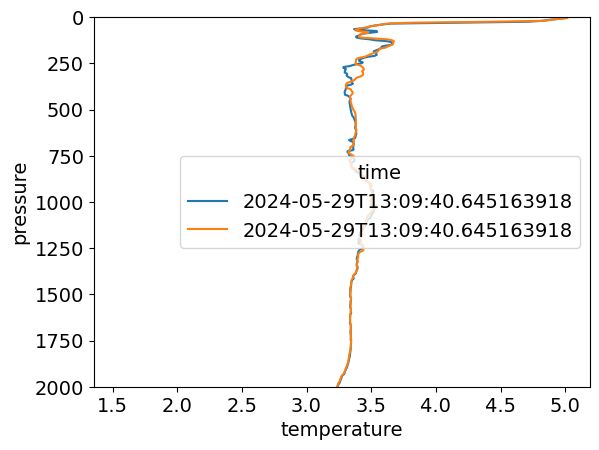

In [199]:
tmp.temperature.plot(y='pressure',hue='time')
plt.ylim(2000,0)

In [353]:
# remove duplicates
tmp_2024 = ar7w_ds.sel(time='2024')

In [355]:
# Create a DataFrame of lat/lon coordinates
coords_df = pd.DataFrame({
    "lat": tmp_2024.latitude.values,
    "lon": tmp_2024.longitude.values
})

# Boolean array of duplicates (True for duplicates except the first occurrence)
duplicates = coords_df.duplicated()

# How many duplicates are there?
print(f"Number of duplicate profiles: {duplicates.sum()}")

Number of duplicate profiles: 61


In [357]:
# Select only the first occurrence of each unique (lat, lon)
tmp_unique = tmp_2024.isel(time=~duplicates).swap_dims({'time':'distance'}).sortby('distance')

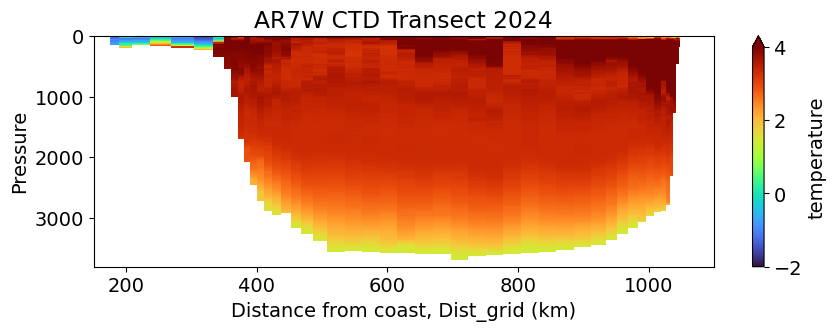

In [359]:
plt.figure(figsize=(10, 3))
tmp_unique.temperature.plot(
    x="distance",
    y="pressure",
    vmin=-2,
    vmax=4,
    cmap="turbo",
    add_colorbar=True
)
plt.title('AR7W CTD Transect 2024')
plt.xlabel('Distance from coast, Dist_grid (km)')
plt.ylabel('Pressure')
plt.ylim(3800, 0)
plt.xlim(150,1100);

In [361]:
tmp_unique

<xarray.Dataset> Size: 2MB
Dimensions:       (distance: 47, pressure: 763)
Coordinates:
    station       (distance) int64 376B ...
  * pressure      (pressure) uint16 2kB 5 10 15 20 25 ... 3800 3805 3815 3820
    time          (distance) datetime64[ns] 376B 2024-06-09T08:54:11.61290500...
    latitude      (distance) float64 376B 53.68 53.8 53.99 ... 60.37 60.41 60.43
    longitude     (distance) float64 376B -55.54 -55.43 -55.25 ... -48.41 -48.41
  * distance      (distance) float64 376B 182.0 196.8 ... 1.045e+03 1.047e+03
    bottom_depth  (distance) float64 376B ...
Data variables:
    salinity      (distance, pressure) float64 287kB ...
    temperature   (distance, pressure) float64 287kB ...
    sigma         (distance, pressure) float64 287kB ...
    sigma0        (distance, pressure) float64 287kB ...
    sigma1        (distance, pressure) float64 287kB ...
    sigma2        (distance, pressure) float64 287kB ...
Attributes:
    source:         Labrador Sea AR7W hydrography
    original_file:  00l3_ 2000d41 8 days.mat

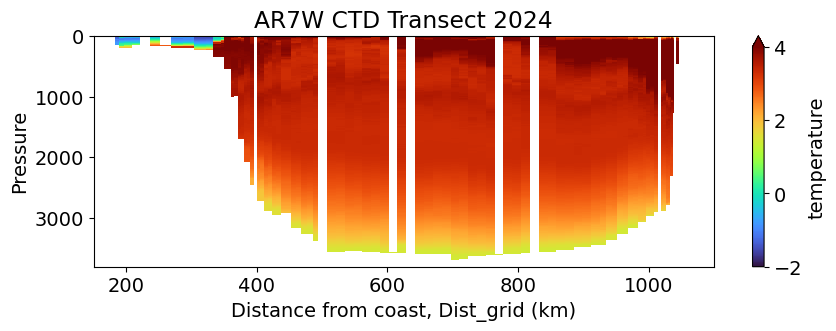

In [275]:
plt.figure(figsize=(10, 3))
tmp.temperature.plot(
    x="distance",
    y="pressure",
    vmin=-2,
    vmax=4,
    cmap="turbo",
    add_colorbar=True
)
plt.title('AR7W CTD Transect 2024')
plt.xlabel('Distance from coast, Dist_grid (km)')
plt.ylabel('Pressure')
plt.ylim(3800, 0)
plt.xlim(150,1100);

In [301]:
non_nan_count = tmp_2024.temperature.notnull().sum(dim='pressure')

In [303]:
# Keep profiles that have more than 1 valid value
keep_mask = non_nan_count > 1

In [341]:
tmp_clean = tmp_2024.isel(time=keep_mask)
tmp_clean

<xarray.Dataset> Size: 3MB
Dimensions:       (time: 93, pressure: 763)
Coordinates:
    station       (time) int64 744B ...
  * pressure      (pressure) uint16 2kB 5 10 15 20 25 ... 3800 3805 3815 3820
  * time          (time) datetime64[ns] 744B 2024-05-29T13:09:40.645163918 .....
    latitude      (time) float64 744B 55.73 55.84 55.84 ... 53.8 53.68 53.68
    longitude     (time) float64 744B -53.51 -53.4 -53.4 ... -55.54 -55.54
    distance      (time) float64 744B ...
    bottom_depth  (time) float64 744B ...
Data variables:
    salinity      (time, pressure) float64 568kB ...
    temperature   (time, pressure) float64 568kB 4.244 4.244 4.245 ... nan nan
    sigma         (time, pressure) float64 568kB ...
    sigma0        (time, pressure) float64 568kB ...
    sigma1        (time, pressure) float64 568kB ...
    sigma2        (time, pressure) float64 568kB ...
Attributes:
    source:         Labrador Sea AR7W hydrography
    original_file:  00l3_ 2000d41 8 days.mat

In [343]:
tmp_clean = tmp_clean.swap_dims({'time':'distance'}).sortby('distance')

In [345]:
# Create a DataFrame of lat/lon coordinates
coords_df_clean = pd.DataFrame({
    "lat": tmp_clean.latitude.values,
    "lon": tmp_clean.longitude.values
})

# Boolean array of duplicates (True for duplicates except the first occurrence)
duplicates_clean = coords_df_clean.duplicated()

# How many duplicates are there?
print(f"Number of duplicate profiles: {duplicates.sum()}")

Number of duplicate profiles: 46


In [347]:
# Select only the first occurrence of each unique (lat, lon)
tmp_clean_unique = tmp_clean.isel(distance=~duplicates_clean)

In [351]:
tmp_clean_unique

<xarray.Dataset> Size: 2MB
Dimensions:       (distance: 47, pressure: 763)
Coordinates:
    station       (distance) int64 376B ...
  * pressure      (pressure) uint16 2kB 5 10 15 20 25 ... 3800 3805 3815 3820
    time          (distance) datetime64[ns] 376B 2024-06-09T08:54:11.61290500...
    latitude      (distance) float64 376B 53.68 53.8 53.99 ... 60.37 60.41 60.43
    longitude     (distance) float64 376B -55.54 -55.43 -55.25 ... -48.41 -48.41
  * distance      (distance) float64 376B 182.0 196.8 ... 1.045e+03 1.047e+03
    bottom_depth  (distance) float64 376B ...
Data variables:
    salinity      (distance, pressure) float64 287kB ...
    temperature   (distance, pressure) float64 287kB 5.016 3.514 ... nan nan
    sigma         (distance, pressure) float64 287kB ...
    sigma0        (distance, pressure) float64 287kB ...
    sigma1        (distance, pressure) float64 287kB ...
    sigma2        (distance, pressure) float64 287kB ...
Attributes:
    source:         Labrador Sea AR7W hydrography
    original_file:  00l3_ 2000d41 8 days.mat